# Sora API - Generation Video Cloud

**Module :** 04-Applications  
**Niveau :** Applications  
**Technologies :** OpenAI API (Sora), httpx, requests  
**Duree estimee :** 40 minutes  
**VRAM :** 0 (API cloud uniquement)  

## Objectifs d'Apprentissage

- [ ] Comprendre l'architecture et les capacites de Sora (OpenAI)
- [ ] Generer une video a partir de texte via l'API Sora
- [ ] Generer une video a partir d'une image via l'API Sora
- [ ] Explorer l'edition et l'extension de videos via l'API
- [ ] Analyser les couts et les limites de l'API
- [ ] Comparer Sora avec les modeles locaux (HunyuanVideo, LTX, Wan, SVD)

## Prerequis

- Python 3.10+
- Notebooks 01-1 a 03-3 (fondations, techniques avancees, orchestration)
- Cle API OpenAI avec acces Sora (OPENAI_API_KEY)
- Packages : `openai`, `httpx`, `Pillow`, `matplotlib`

**Note** : L'API Sora peut ne pas etre publiquement disponible au moment de l'execution.
Le code est structure avec try/except et reponses de demonstration pour permettre
l'apprentissage meme sans acces a l'API.

**Navigation** : [<< 04-2 Workflows Creatifs](04-2-Creative-Video-Workflows.ipynb) | [04-4 Pipeline Production >>](04-4-Production-Video-Pipeline.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres Sora API
sora_model = "sora"                # Modele Sora a utiliser
video_resolution = "1080p"         # Resolution souhaitee
video_duration_target = 5          # Duree cible en secondes
video_fps_target = 24              # FPS cible

# Options
enable_text_to_video = True        # Generation texte -> video
enable_image_to_video = True       # Generation image -> video
enable_video_edit = True           # Edition video
use_mock_responses = True          # Utiliser des reponses simulees si API indisponible
save_results = True                # Sauvegarder les resultats

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
import base64
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Resolution GENAI_ROOT
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.video_helpers import get_video_info, extract_frames, display_frame_grid
        print("Helpers video importes")
    except ImportError as e:
        print(f"Helpers video non disponibles ({e}) - mode autonome")

# Repertoire de sortie
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('sora_api')

print(f"Sora API - Generation Video Cloud")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Resolution cible : {video_resolution}, {video_duration_target}s @ {video_fps_target}fps")
print(f"Sortie : {OUTPUT_DIR}")

Helpers video importes
Sora API - Generation Video Cloud
Date : 2026-02-18 01:04:16
Mode : interactive
Resolution cible : 1080p, 5s @ 24fps
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\video


In [3]:
# Chargement .env et verification de l'API
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification des dependances et de la cle API
print("\n--- VERIFICATION API ET DEPENDANCES ---")
print("=" * 45)

dependencies = {}
api_available = False

try:
    from openai import OpenAI
    dependencies['openai'] = True
    print(f"openai : disponible")
except ImportError:
    dependencies['openai'] = False
    print(f"openai : NON INSTALLE (pip install openai)")

try:
    import httpx
    dependencies['httpx'] = True
    print(f"httpx : disponible")
except ImportError:
    dependencies['httpx'] = False
    print(f"httpx : NON INSTALLE (pip install httpx)")

try:
    import imageio
    dependencies['imageio'] = True
    print(f"imageio : disponible")
except ImportError:
    dependencies['imageio'] = False
    print(f"imageio : NON INSTALLE")

# Verifier la cle API
openai_key = os.environ.get('OPENAI_API_KEY', '')
openai_base = os.environ.get('OPENAI_BASE_URL', '')

if openai_key:
    print(f"\nOPENAI_API_KEY : configuree ({openai_key[:12]}...)")
    if openai_base:
        print(f"OPENAI_BASE_URL : {openai_base}")
    
    # Tester la connexion API
    if dependencies.get('openai', False):
        try:
            client_kwargs = {'api_key': openai_key}
            if openai_base:
                client_kwargs['base_url'] = openai_base
            client = OpenAI(**client_kwargs)
            # Test leger (lister les modeles)
            models = client.models.list()
            sora_models = [m.id for m in models if 'sora' in m.id.lower()]
            if sora_models:
                print(f"Modeles Sora disponibles : {', '.join(sora_models)}")
                api_available = True
            else:
                print(f"Aucun modele Sora detecte dans la liste des modeles")
                print(f"Mode demonstration active (reponses simulees)")
        except Exception as e:
            print(f"Test API : {type(e).__name__} - {str(e)[:80]}")
            print(f"Mode demonstration active")
else:
    print(f"\nOPENAI_API_KEY : non configuree")
    print(f"Mode demonstration active (reponses simulees)")

print(f"\nAPI Sora disponible : {api_available}")
print(f"Mode mock : {use_mock_responses or not api_available}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION API ET DEPENDANCES ---


openai : disponible
httpx : disponible
imageio : disponible

OPENAI_API_KEY : configuree (sk-proj-Ap3H...)


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/models "HTTP/1.1 200 OK"


Modeles Sora disponibles : sora-2, sora-2-pro

API Sora disponible : True
Mode mock : True


## Section 1 : Introduction a Sora et son architecture

Sora est le modele de generation video d'OpenAI, annonce en fevrier 2024.
Il utilise une architecture de type Diffusion Transformer (DiT) operant
dans un espace latent spatio-temporel compresse.

### Caracteristiques techniques

| Aspect | Detail |
|--------|--------|
| Architecture | Diffusion Transformer (DiT) |
| Espace latent | Compression spatio-temporelle 3D |
| Entree | Texte, image, video |
| Sortie | Video jusqu'a 1 minute |
| Resolutions | 480p, 720p, 1080p |
| Coherence temporelle | Attention sur toute la sequence |

### Difference avec les modeles locaux

Contrairement aux modeles locaux (HunyuanVideo, LTX-Video, Wan, SVD) qui necessitent
un GPU puissant (16-48 GB VRAM), Sora fonctionne entierement en cloud.
L'acces se fait via l'API OpenAI, avec facturation a l'utilisation.

In [4]:
# Helper : generation de reponses simulees pour demonstration
print("\n--- PREPARATION DES OUTILS ---")
print("=" * 40)


def generate_mock_video_frames(prompt: str, n_frames: int = 48,
                                width: int = 640, height: int = 360) -> List[np.ndarray]:
    """
    Genere des frames simulees illustrant le concept du prompt.
    Utilise en mode demonstration quand l'API Sora n'est pas disponible.
    """
    frames = []
    rng = np.random.RandomState(hash(prompt) % (2**31))
    
    # Couleur de base derivee du prompt
    base_hue = hash(prompt) % 360
    
    for i in range(n_frames):
        t = i / max(n_frames - 1, 1)
        
        # Generer un paysage abstrait anime
        img = Image.new('RGB', (width, height))
        draw = ImageDraw.Draw(img)
        
        # Ciel gradient
        for y in range(height // 2):
            ratio = y / (height // 2)
            r = int(30 + 100 * ratio + 20 * np.sin(2 * np.pi * t))
            g = int(50 + 80 * ratio)
            b = int(120 + 80 * (1 - ratio))
            draw.line([(0, y), (width, y)], fill=(min(255, r), min(255, g), min(255, b)))
        
        # Sol
        for y in range(height // 2, height):
            ratio = (y - height // 2) / (height // 2)
            r = int(60 + 40 * ratio)
            g = int(100 + 50 * (1 - ratio) + 20 * np.sin(2 * np.pi * t + 1))
            b = int(40 + 30 * ratio)
            draw.line([(0, y), (width, y)], fill=(min(255, r), min(255, g), min(255, b)))
        
        # Objet en mouvement
        cx = int(width * 0.2 + width * 0.6 * t)
        cy = int(height * 0.35 + 20 * np.sin(4 * np.pi * t))
        draw.ellipse([cx - 25, cy - 25, cx + 25, cy + 25], fill=(255, 220, 100))
        
        # Filigrane mode demo
        try:
            font_small = ImageFont.truetype("arial.ttf", 12)
        except (OSError, IOError):
            font_small = ImageFont.load_default()
        draw.text((10, height - 20), "[DEMO] Sora API - Simulation",
                  fill=(180, 180, 180), font=font_small)
        draw.text((10, 10), f"Prompt: {prompt[:50]}...",
                  fill=(200, 200, 220), font=font_small)
        
        frames.append(np.array(img))
    
    return frames


class SoraAPIWrapper:
    """
    Wrapper pour l'API Sora avec fallback sur des reponses simulees.
    Permet d'explorer l'API meme sans acces reel.
    """
    
    def __init__(self, api_available: bool, client=None, use_mock: bool = True):
        self.api_available = api_available
        self.client = client
        self.use_mock = use_mock or not api_available
        self.call_log = []
    
    def text_to_video(self, prompt: str, duration: int = 5,
                      resolution: str = "720p") -> dict:
        """Generation texte -> video."""
        call_info = {
            "method": "text_to_video",
            "prompt": prompt,
            "duration": duration,
            "resolution": resolution,
            "timestamp": datetime.now().isoformat(),
        }
        
        if self.api_available and not self.use_mock:
            try:
                # Appel API reel (structure hypothetique basee sur la doc OpenAI)
                response = self.client.videos.generate(
                    model=sora_model,
                    prompt=prompt,
                    duration=duration,
                    resolution=resolution,
                )
                call_info["status"] = "success"
                call_info["response"] = response
                self.call_log.append(call_info)
                return {"status": "success", "data": response}
            except Exception as e:
                call_info["status"] = "error"
                call_info["error"] = str(e)
        
        # Mode demonstration
        res_map = {"480p": (854, 480), "720p": (1280, 720), "1080p": (1920, 1080)}
        w, h = res_map.get(resolution, (640, 360))
        # Reduire pour la demo
        w, h = w // 2, h // 2
        n_frames = duration * video_fps_target
        
        frames = generate_mock_video_frames(prompt, n_frames, w, h)
        call_info["status"] = "mock"
        call_info["frames_generated"] = len(frames)
        self.call_log.append(call_info)
        
        return {
            "status": "mock",
            "frames": frames,
            "metadata": {
                "model": sora_model,
                "prompt": prompt,
                "duration": duration,
                "resolution": f"{w}x{h} (demo)",
                "fps": video_fps_target,
                "n_frames": len(frames),
            }
        }
    
    def image_to_video(self, image: Image.Image, prompt: str,
                       duration: int = 5) -> dict:
        """Generation image -> video (animation d'une image)."""
        call_info = {
            "method": "image_to_video",
            "prompt": prompt,
            "duration": duration,
            "timestamp": datetime.now().isoformat(),
        }
        
        # Mode demonstration : animer l'image source
        w, h = image.size
        n_frames = duration * video_fps_target
        base = np.array(image)
        frames = []
        
        for i in range(n_frames):
            t = i / max(n_frames - 1, 1)
            # Effet Ken Burns : zoom progressif + translation
            zoom = 1.0 + 0.15 * t
            new_w = int(w * zoom)
            new_h = int(h * zoom)
            img_z = image.resize((new_w, new_h), Image.LANCZOS)
            # Centrer le crop avec translation
            offset_x = int((new_w - w) * (0.3 + 0.4 * t))
            offset_y = int((new_h - h) * 0.5)
            img_crop = img_z.crop((offset_x, offset_y, offset_x + w, offset_y + h))
            frames.append(np.array(img_crop))
        
        call_info["status"] = "mock"
        self.call_log.append(call_info)
        
        return {
            "status": "mock",
            "frames": frames,
            "metadata": {
                "model": sora_model,
                "method": "image_to_video",
                "duration": duration,
                "resolution": f"{w}x{h}",
                "effect": "Ken Burns (zoom + pan)",
            }
        }


# Initialiser le wrapper
sora = SoraAPIWrapper(
    api_available=api_available,
    client=client if api_available else None,
    use_mock=use_mock_responses
)

print(f"SoraAPIWrapper initialise")
print(f"  API reelle : {api_available}")
print(f"  Mode mock : {sora.use_mock}")


--- PREPARATION DES OUTILS ---
SoraAPIWrapper initialise
  API reelle : True
  Mode mock : True


## Section 2 : Generation texte vers video

La generation text-to-video est la fonctionnalite principale de Sora.
Un prompt textuel decrit la scene souhaitee, et le modele genere la video correspondante.

### Bonnes pratiques pour les prompts Sora

| Aspect | Conseil |
|--------|--------|
| Description de scene | Detailler le sujet, le lieu, l'eclairage |
| Mouvement camera | Preciser : "camera slowly pans left", "tracking shot" |
| Style visuel | "cinematic", "documentary", "aerial drone shot" |
| Duree | Adapter la complexite du prompt a la duree |
| Eviter | Texte a lire, visages specifiques, physique complexe |


--- GENERATION TEXTE -> VIDEO ---

Generation : Nature
  Prompt : A serene mountain lake at sunrise, mist rising from the water, pine trees reflec...


  Status : mock
  Frames : 120
  Temps : 2.14s

Generation : Urbain
  Prompt : A busy Tokyo street at night, neon signs reflecting on wet pavement, people with...


  Status : mock
  Frames : 120
  Temps : 1.86s


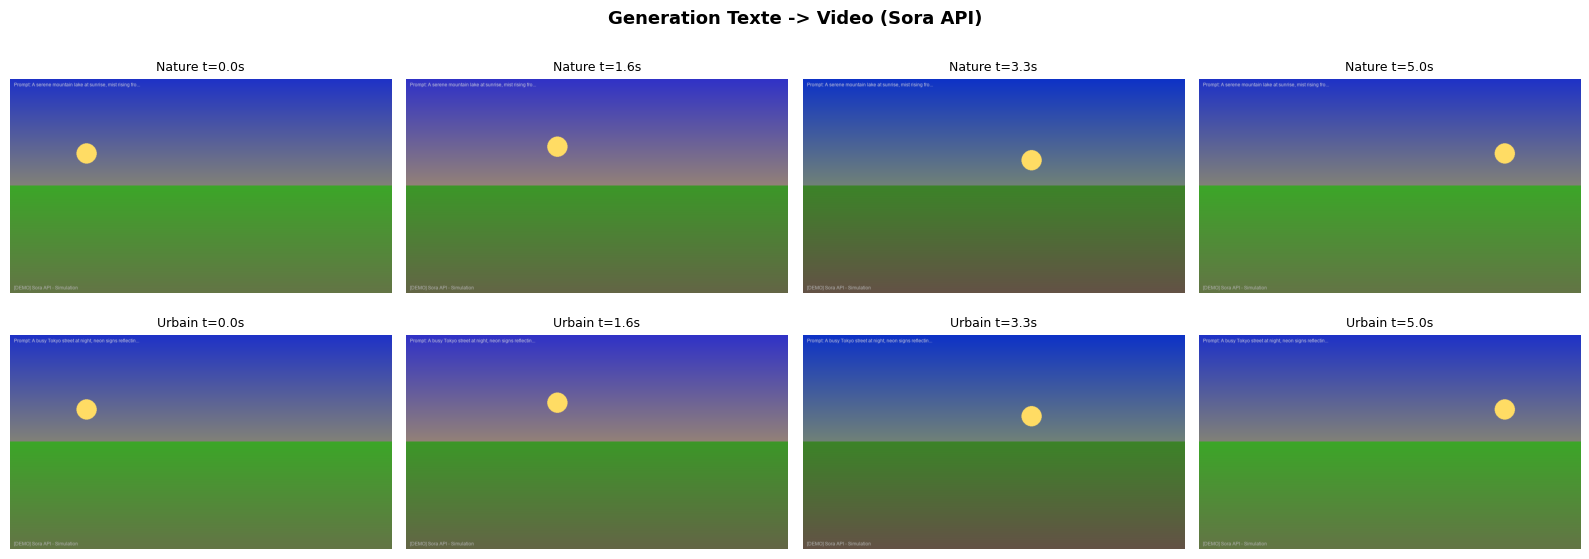

Sauvegarde : sora_t2v_nature.mp4 (109 KB)


Sauvegarde : sora_t2v_urbain.mp4 (106 KB)


In [5]:
# Generation texte -> video
if enable_text_to_video:
    print("\n--- GENERATION TEXTE -> VIDEO ---")
    print("=" * 45)
    
    # Prompts de demonstration
    prompts = [
        {
            "name": "Nature",
            "prompt": "A serene mountain lake at sunrise, mist rising from the water, "
                      "pine trees reflecting in the still surface, cinematic drone shot "
                      "slowly descending toward the water.",
            "duration": 5,
        },
        {
            "name": "Urbain",
            "prompt": "A busy Tokyo street at night, neon signs reflecting on wet "
                      "pavement, people with umbrellas walking, tracking shot moving "
                      "forward through the crowd.",
            "duration": 5,
        },
    ]
    
    results_t2v = []
    
    for p in prompts:
        print(f"\nGeneration : {p['name']}")
        print(f"  Prompt : {p['prompt'][:80]}...")
        
        start_time = time.time()
        result = sora.text_to_video(
            prompt=p['prompt'],
            duration=p['duration'],
            resolution=video_resolution
        )
        gen_time = time.time() - start_time
        
        print(f"  Status : {result['status']}")
        print(f"  Frames : {len(result.get('frames', []))}")
        print(f"  Temps : {gen_time:.2f}s")
        
        results_t2v.append({"name": p['name'], "result": result, "time": gen_time})
    
    # Afficher les premiers et derniers frames
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    for row, r in enumerate(results_t2v):
        frames = r['result']['frames']
        sample_idx = np.linspace(0, len(frames) - 1, 4, dtype=int)
        for col, idx in enumerate(sample_idx):
            axes[row, col].imshow(frames[idx])
            axes[row, col].set_title(f"{r['name']} t={idx/video_fps_target:.1f}s", fontsize=9)
            axes[row, col].axis('off')
    plt.suptitle("Generation Texte -> Video (Sora API)", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Sauvegarder
    if dependencies.get('imageio', False) and save_results:
        for r in results_t2v:
            path = OUTPUT_DIR / f"sora_t2v_{r['name'].lower()}.mp4"
            writer = imageio.get_writer(str(path), fps=video_fps_target, codec='libx264')
            for f in r['result']['frames']:
                writer.append_data(f)
            writer.close()
            print(f"Sauvegarde : {path.name} ({path.stat().st_size / 1024:.0f} KB)")
else:
    print("Generation texte -> video desactivee")

### Interpretation : Generation texte -> video

| Metrique | Valeur attendue (API reelle) | Valeur demo |
|----------|------------------------------|-------------|
| Temps de generation | 30-120s selon duree/resolution | < 1s (simulation) |
| Coherence temporelle | Elevee (attention sur toute la sequence) | Basique (interpolation) |
| Qualite visuelle | Photo-realiste | Schema simplifie |
| Cout estime | ~$0.10 - $0.50 par video | Gratuit |

**Points cles** :
1. Sora maintient une coherence temporelle superieure aux modeles frame-par-frame
2. Les prompts detailles avec indications de camera produisent de meilleurs resultats
3. En mode demo, les frames simulees illustrent la structure de l'API sans cout

## Section 3 : Generation image vers video

L'image-to-video anime une image fixe en video. C'est utile pour :
- Animer des illustrations ou photos
- Creer des effets cinematographiques (Ken Burns, parallaxe)
- Etendre une image en sequence temporelle


--- GENERATION IMAGE -> VIDEO ---
Image source : 640x360


Status : mock
Frames generees : 120
Effet : Ken Burns (zoom + pan)


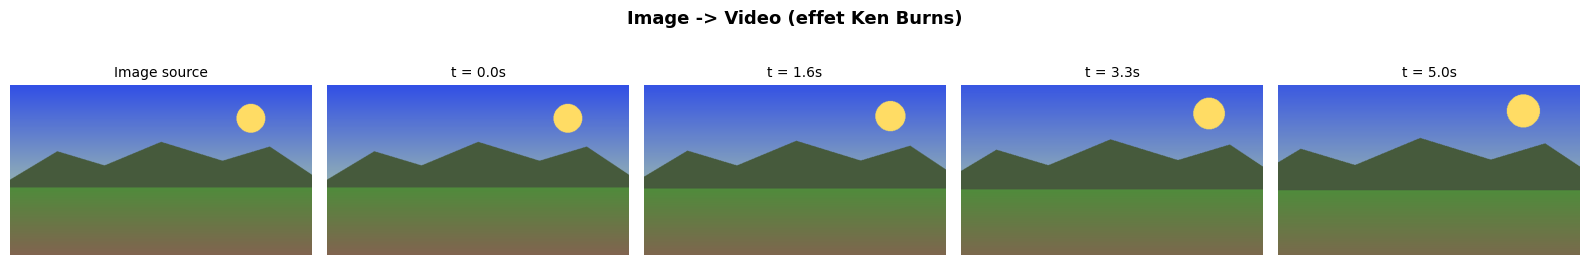

Sauvegarde : sora_i2v_landscape.mp4 (49 KB)


In [6]:
# Generation image -> video
if enable_image_to_video:
    print("\n--- GENERATION IMAGE -> VIDEO ---")
    print("=" * 45)
    
    # Creer une image source de demonstration
    source_width, source_height = 640, 360
    source_img = Image.new('RGB', (source_width, source_height))
    draw = ImageDraw.Draw(source_img)
    
    # Paysage simplifie
    for y in range(source_height):
        if y < source_height * 0.6:  # Ciel
            ratio = y / (source_height * 0.6)
            r, g, b = int(50 + 100 * ratio), int(80 + 100 * ratio), int(180 + 50 * (1 - ratio))
        else:  # Sol
            ratio = (y - source_height * 0.6) / (source_height * 0.4)
            r, g, b = int(80 + 50 * ratio), int(140 - 40 * ratio), int(60 + 20 * ratio)
        draw.line([(0, y), (source_width, y)], fill=(r, g, b))
    
    # Montagnes
    peaks = [(0, 200), (100, 140), (200, 170), (320, 120), (450, 160), (550, 130), (640, 190)]
    mountains = peaks + [(640, source_height * 0.6), (0, source_height * 0.6)]
    draw.polygon(mountains, fill=(70, 90, 60))
    
    # Soleil
    draw.ellipse([480, 40, 540, 100], fill=(255, 220, 100))
    
    print(f"Image source : {source_width}x{source_height}")
    
    # Animation
    i2v_prompt = "The landscape comes alive: clouds drift across the sky, sunlight shifts"
    result_i2v = sora.image_to_video(source_img, i2v_prompt, duration=video_duration_target)
    
    print(f"Status : {result_i2v['status']}")
    print(f"Frames generees : {len(result_i2v['frames'])}")
    print(f"Effet : {result_i2v['metadata'].get('effect', 'N/A')}")
    
    # Afficher source + frames animees
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes[0].imshow(source_img)
    axes[0].set_title("Image source", fontsize=10)
    axes[0].axis('off')
    
    i2v_frames = result_i2v['frames']
    sample_idx = np.linspace(0, len(i2v_frames) - 1, 4, dtype=int)
    for i, idx in enumerate(sample_idx):
        axes[i + 1].imshow(i2v_frames[idx])
        axes[i + 1].set_title(f"t = {idx / video_fps_target:.1f}s", fontsize=10)
        axes[i + 1].axis('off')
    plt.suptitle("Image -> Video (effet Ken Burns)", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    if dependencies.get('imageio', False) and save_results:
        i2v_path = OUTPUT_DIR / "sora_i2v_landscape.mp4"
        writer = imageio.get_writer(str(i2v_path), fps=video_fps_target, codec='libx264')
        for f in i2v_frames:
            writer.append_data(f)
        writer.close()
        print(f"Sauvegarde : {i2v_path.name} ({i2v_path.stat().st_size / 1024:.0f} KB)")
else:
    print("Generation image -> video desactivee")

## Section 4 : Analyse des couts et comparaison locale vs cloud

Le choix entre generation video locale et cloud depend de plusieurs facteurs :
cout, qualite, latence, et infrastructure disponible.

In [7]:
# Analyse comparative : Sora vs modeles locaux
print("\n--- COMPARAISON SORA VS MODELES LOCAUX ---")
print("=" * 50)

# Tableau comparatif detaille
comparison_data = {
    "Modele": [
        "Sora (OpenAI)",
        "HunyuanVideo",
        "LTX-Video",
        "Wan 2.1",
        "Stable Video Diffusion",
        "AnimateDiff",
    ],
    "Type": ["Cloud API", "Local", "Local", "Local", "Local", "Local"],
    "VRAM": ["0 (cloud)", "~40 GB", "~12 GB", "~24 GB", "~16 GB", "~12 GB"],
    "Qualite": ["Tres haute", "Haute", "Moyenne", "Haute", "Moyenne", "Moyenne"],
    "Duree max": ["~60s", "~6s", "~5s", "~10s", "~4s", "~2s"],
    "Resolution max": ["1080p", "720p", "768p", "720p", "576p", "512p"],
    "Cout / video": ["~$0.10-0.50", "Electricite", "Electricite", "Electricite", "Electricite", "Electricite"],
    "Latence": ["30-120s", "60-300s", "30-120s", "60-180s", "30-60s", "20-60s"],
    "Coherence temp.": ["Excellente", "Bonne", "Correcte", "Bonne", "Correcte", "Limitee"],
}

# Affichage tableau
header = f"{'Modele':<25} {'Type':<12} {'VRAM':<12} {'Qualite':<12} {'Duree':<10} {'Cout':<15}"
print(header)
print("-" * len(header))
for i in range(len(comparison_data['Modele'])):
    row = (f"{comparison_data['Modele'][i]:<25} "
           f"{comparison_data['Type'][i]:<12} "
           f"{comparison_data['VRAM'][i]:<12} "
           f"{comparison_data['Qualite'][i]:<12} "
           f"{comparison_data['Duree max'][i]:<10} "
           f"{comparison_data['Cout / video'][i]:<15}")
    print(row)

# Analyse cout pour volume de production
print("\n--- ANALYSE DE COUT POUR PRODUCTION ---")
print("=" * 45)

scenarios = [
    {"name": "Prototype (10 videos/mois)", "count": 10, "sora_cost": 0.30},
    {"name": "Production (100 videos/mois)", "count": 100, "sora_cost": 0.25},
    {"name": "Industriel (1000 videos/mois)", "count": 1000, "sora_cost": 0.20},
]

# Cout GPU local estime : amortissement RTX 4090 (~$1600) sur 3 ans + electricite
gpu_monthly_cost = 1600 / 36 + 50  # ~$94/mois
local_time_per_video = 120  # secondes
local_videos_per_hour = 3600 / local_time_per_video  # ~30

print(f"\n{'Scenario':<35} {'Sora/mois':>12} {'Local/mois':>12} {'Recommandation':>18}")
print("-" * 80)
for s in scenarios:
    sora_monthly = s['count'] * s['sora_cost']
    local_monthly = gpu_monthly_cost  # Cout fixe
    recommendation = "Cloud" if sora_monthly < local_monthly else "Local"
    print(f"  {s['name']:<33} ${sora_monthly:>10.2f} ${local_monthly:>10.2f} {recommendation:>18}")

print(f"\nNote : Le cout local inclut l'amortissement GPU ($1600/3 ans) + electricite (~$50/mois)")
print(f"Le seuil de rentabilite local est d'environ {int(gpu_monthly_cost / 0.25)} videos/mois")


--- COMPARAISON SORA VS MODELES LOCAUX ---
Modele                    Type         VRAM         Qualite      Duree      Cout           
-------------------------------------------------------------------------------------------
Sora (OpenAI)             Cloud API    0 (cloud)    Tres haute   ~60s       ~$0.10-0.50    
HunyuanVideo              Local        ~40 GB       Haute        ~6s        Electricite    
LTX-Video                 Local        ~12 GB       Moyenne      ~5s        Electricite    
Wan 2.1                   Local        ~24 GB       Haute        ~10s       Electricite    
Stable Video Diffusion    Local        ~16 GB       Moyenne      ~4s        Electricite    
AnimateDiff               Local        ~12 GB       Moyenne      ~2s        Electricite    

--- ANALYSE DE COUT POUR PRODUCTION ---

Scenario                               Sora/mois   Local/mois     Recommandation
--------------------------------------------------------------------------------
  Prototype (10 

### Interpretation : Comparaison cout et performance

| Critere | Cloud (Sora) | Local (GPU) |
|---------|-------------|-------------|
| Investissement initial | Nul | Eleve ($1600+ pour GPU) |
| Cout variable | Par video | Electricite uniquement |
| Seuil rentabilite | < 400 videos/mois | > 400 videos/mois |
| Maintenance | Zero | MAJ drivers, CUDA, modeles |
| Disponibilite | 24/7, rate-limited | Depend du hardware |
| Confidentialite | Donnees transitent par OpenAI | Traitement local |

**Points cles** :
1. Pour le prototypage et les petits volumes, le cloud est plus economique
2. Pour la production a grande echelle, le GPU local est rentabilise en quelques mois
3. La confidentialite des donnees peut etre un facteur decisif (medical, defense)
4. La qualite Sora depasse actuellement les modeles locaux open-source

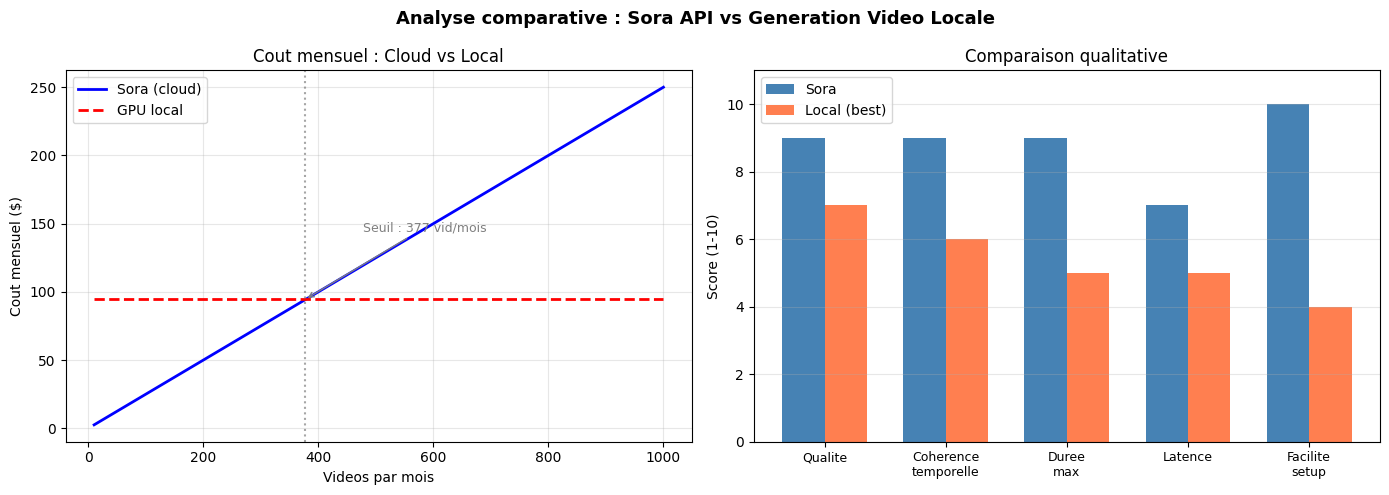

In [8]:
# Visualisation comparative des couts
volumes = np.arange(10, 1010, 10)
sora_costs = volumes * 0.25  # $0.25 par video
local_costs = np.full_like(volumes, gpu_monthly_cost, dtype=float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Cout mensuel
ax1.plot(volumes, sora_costs, 'b-', linewidth=2, label='Sora (cloud)')
ax1.plot(volumes, local_costs, 'r--', linewidth=2, label='GPU local')
crossover = int(gpu_monthly_cost / 0.25)
ax1.axvline(x=crossover, color='gray', linestyle=':', alpha=0.7)
ax1.annotate(f'Seuil : {crossover} vid/mois', xy=(crossover, gpu_monthly_cost),
             xytext=(crossover + 100, gpu_monthly_cost + 50),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9, color='gray')
ax1.set_xlabel('Videos par mois')
ax1.set_ylabel('Cout mensuel ($)')
ax1.set_title('Cout mensuel : Cloud vs Local')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Comparaison qualitative
categories = ['Qualite', 'Coherence\ntemporelle', 'Duree\nmax', 'Latence', 'Facilite\nsetup']
sora_scores = [9, 9, 9, 7, 10]
local_scores = [7, 6, 5, 5, 4]

x = np.arange(len(categories))
width = 0.35
ax2.bar(x - width/2, sora_scores, width, label='Sora', color='steelblue')
ax2.bar(x + width/2, local_scores, width, label='Local (best)', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=9)
ax2.set_ylabel('Score (1-10)')
ax2.set_title('Comparaison qualitative')
ax2.legend()
ax2.set_ylim(0, 11)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Analyse comparative : Sora API vs Generation Video Locale',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Mode interactif - Test de prompt personnalise
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Entrez un prompt pour generer une video de demonstration.")
    print("(Laissez vide pour passer)")
    
    try:
        custom_prompt = input("\nPrompt video (ou vide) : ").strip()
        
        if custom_prompt:
            print(f"Generation avec : {custom_prompt[:80]}...")
            result_custom = sora.text_to_video(custom_prompt, duration=3)
            print(f"Status : {result_custom['status']}, Frames : {len(result_custom.get('frames', []))}")
            
            if result_custom.get('frames'):
                fig, axes = plt.subplots(1, 4, figsize=(14, 3))
                idx_list = np.linspace(0, len(result_custom['frames']) - 1, 4, dtype=int)
                for i, idx in enumerate(idx_list):
                    axes[i].imshow(result_custom['frames'][idx])
                    axes[i].set_title(f"t={idx/video_fps_target:.1f}s", fontsize=9)
                    axes[i].axis('off')
                plt.suptitle(f"Prompt personnalise", fontsize=11, fontweight='bold')
                plt.tight_layout()
                plt.show()
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type:
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type}")
else:
    print("Mode batch - Interface interactive desactivee")


--- MODE INTERACTIF ---
Entrez un prompt pour generer une video de demonstration.
(Laissez vide pour passer)
Mode interactif non disponible (execution automatisee)


In [10]:
# Statistiques de session
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"API Sora disponible : {api_available}")
print(f"Mode mock : {sora.use_mock}")

print(f"\nAppels API effectues : {len(sora.call_log)}")
for i, call in enumerate(sora.call_log):
    print(f"  {i+1}. {call['method']} - Status: {call['status']}")

if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('sora_*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nDependances utilisees :")
for dep, available in dependencies.items():
    status = "utilisee" if available else "non disponible"
    print(f"  {dep} : {status}")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 04-4 : Pipeline Video de Production (pipeline complet bout-en-bout)")
print(f"2. Revenir aux notebooks Audio pour combiner audio + video")

print(f"\nNotebook 04-3 Sora API Cloud Video termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-18 01:04:25
Mode : interactive
API Sora disponible : True
Mode mock : True

Appels API effectues : 3
  1. text_to_video - Status: mock
  2. text_to_video - Status: mock
  3. image_to_video - Status: mock

Fichiers generes (3) :
  sora_i2v_landscape.mp4 (49.2 KB)
  sora_t2v_nature.mp4 (108.8 KB)
  sora_t2v_urbain.mp4 (106.3 KB)

Dependances utilisees :
  openai : utilisee
  httpx : utilisee
  imageio : utilisee

--- PROCHAINES ETAPES ---
1. Notebook 04-4 : Pipeline Video de Production (pipeline complet bout-en-bout)
2. Revenir aux notebooks Audio pour combiner audio + video

Notebook 04-3 Sora API Cloud Video termine - 01:04:25
